In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [2]:
df = pd.read_csv('data.csv', encoding='unicode_escape')

df.shape

(9994, 11)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     9994 non-null   object 
 1   order_id        9994 non-null   object 
 2   order_date      9994 non-null   object 
 3   city            9994 non-null   object 
 4   product_id      9994 non-null   object 
 5   category        9994 non-null   object 
 6   sub_category    9994 non-null   object 
 7   product_name    9994 non-null   object 
 8   total_excl_vat  9994 non-null   float64
 9   quantity        9994 non-null   int64  
 10  discount        9994 non-null   float64
dtypes: float64(2), int64(1), object(8)
memory usage: 859.0+ KB


In [4]:
df.head()

,customer_id,order_id,order_date,city,product_id,category,sub_category,product_name,total_excl_vat,quantity,discount
0,CG-12520,CA-2016-152156,11/8/2016,Henderson,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00
1,CG-12520,CA-2016-152156,11/8/2016,Henderson,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00
2,DV-13045,CA-2016-138688,6/12/2016,Los Angeles,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00
3,SO-20335,US-2015-108966,10/11/2015,Fort Lauderdale,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45
4,SO-20335,US-2015-108966,10/11/2015,Fort Lauderdale,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20


In [5]:
# Check for rows with a negative quantity and price.
print(len(df[df['quantity'] < 0 ]))
print(len(df[df['total_excl_vat'] < 0 ]))

0
0


## Exploratory Data Analysis

In [6]:
#convert order_date to date
df['order_date'] = df['order_date'].apply(pd.to_datetime)

df['year_month'] = df['order_date'].dt.strftime('%Y-%m')

In [7]:
# calculate revenue for each row.
df['revenue'] = df['total_excl_vat'] * df['quantity']

### Number of Orders by City

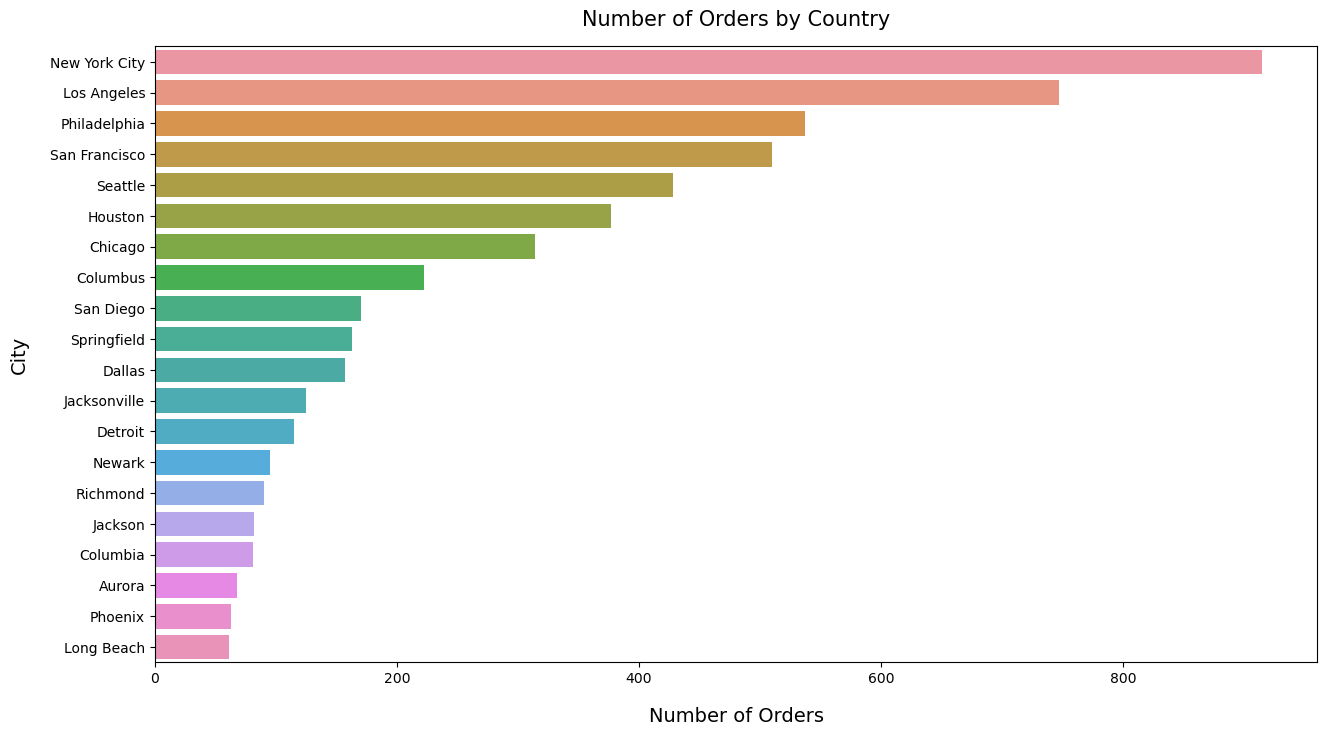

In [8]:
# Plot top 20 number of orders by city.
plt.figure(figsize=(15,8))
s = sns.barplot(data=df.groupby('city')['order_date'].count().sort_values(ascending=False).nlargest(20).reset_index(),
                y='city', x='order_date', linewidth=0)
s.set_title('Number of Orders by Country', y=1.02, fontsize=15)
s.set_xlabel('Number of Orders', fontsize=14, labelpad=15)
s.set_ylabel('City', fontsize=14, labelpad=15)
plt.show()


Observations:

- The shop seems to be overly reliant on NewYork city and Los Angeles for its business and could face a downturn in business if these market were to have economic or other problems.

Recommendations:

- The shop has significant opportunity to grow its business in other cities markets. Marketing efforts should be increased in these other markets, to increase the customer base and to grow revenue.

In [9]:
# Display top 10 customers by discount.
discount = df.loc[df.discount > 0]
discount.groupby('customer_id')['order_id'].nunique().nlargest(10).reset_index()

,customer_id,order_id
0,CK-12205,12
1,LC-16885,11
2,SH-19975,10
3,BP-11095,9
4,CS-11950,9
5,EB-13705,9
6,EB-13870,9
7,EP-13915,9
8,MA-17560,9
9,NS-18640,9


Recommendation

- For discount customers do well to always alart them during discount seasons as they will always buy


### Monthly Revenue

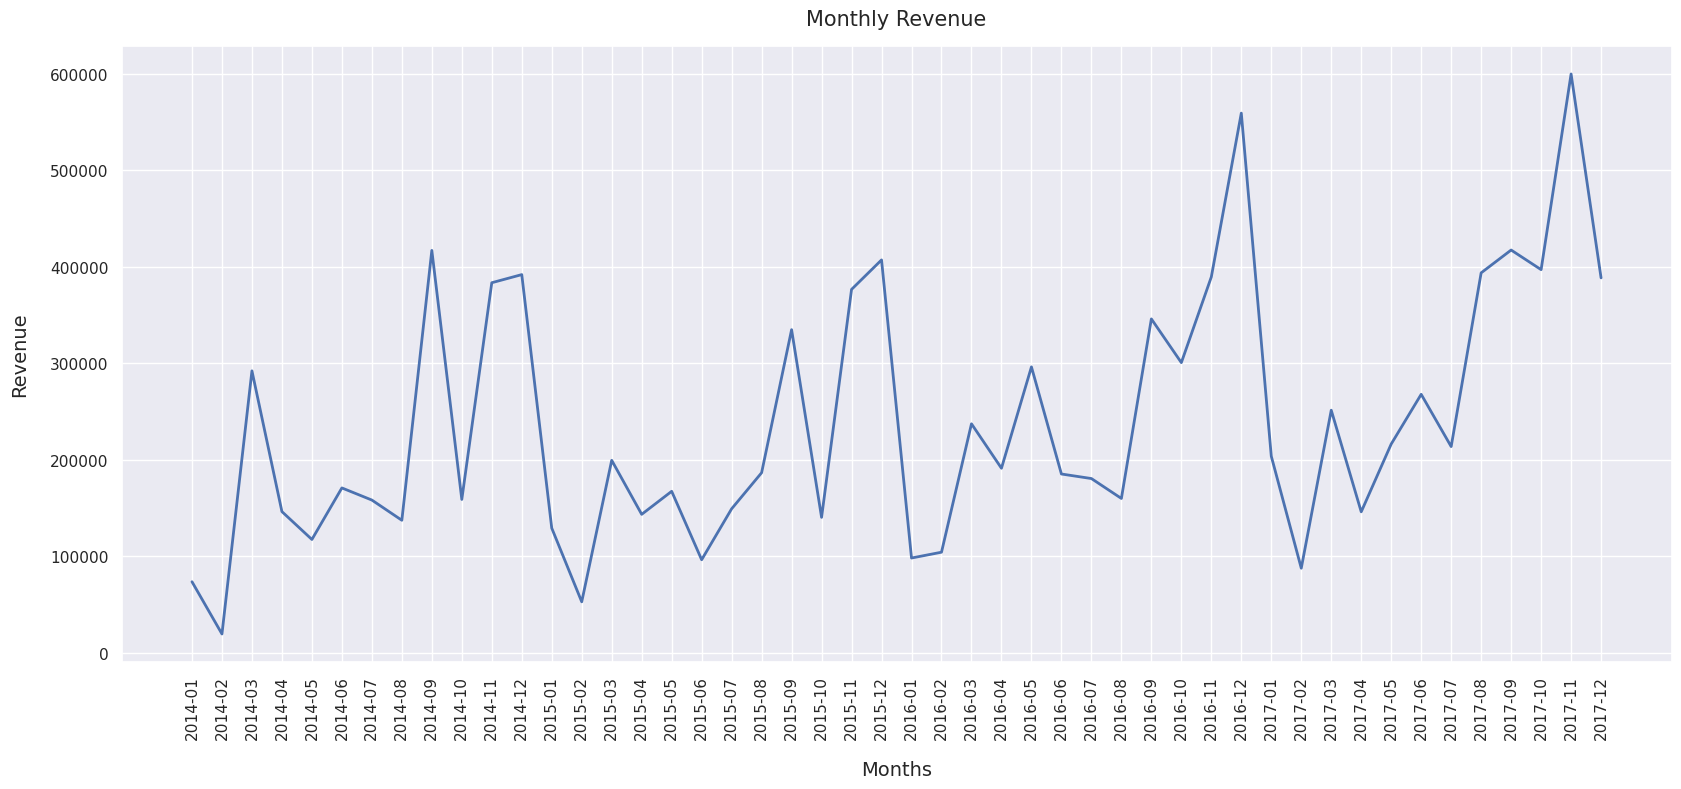

In [10]:
# Calculate monthly revenue.
df_revenue = df.groupby(['year_month'])['revenue'].sum().reset_index()

sns.set_theme(style='darkgrid')
plt.figure(figsize=(20,8))
s = sns.lineplot(data=df_revenue, color='b', linewidth=2, legend=None)
s.set_title('Monthly Revenue', y=1.02, fontsize=15)
s.set_xlabel('Months', fontsize=14, labelpad=15)
s.set_ylabel('Revenue', fontsize=14, labelpad=15)
plt.xticks(np.arange(len(df_revenue['year_month'])), df_revenue['year_month'], rotation=90)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Observations:

- Monthly revenue is fairly consistent in Q1 - Q3 each year, ranging between \$150k and \\$300k.
- There is a cyclical increase in monthly sales during Q4 of each year, likely explained by the holidays in the quarter, of which Christmas is the primary holiday. 
- There is also  growth in sales in December every year 

In [11]:
# Display top 10 customers by revenue.
df.groupby('customer_id')['revenue'].sum().nlargest(10).reset_index()

,customer_id,revenue
0,SM-20320,146749.7700
1,AB-10105,143857.7090
2,TC-20980,92602.5740
3,BM-11140,88175.2660
4,JH-15985,80520.0420
5,KL-16645,74912.3130
6,GT-14710,73016.0520
7,ME-17320,71594.2960
8,BS-11365,71586.3310
9,PO-18850,69297.4106


Observations:

- The top 2 customers over the four year period have a spend signficantly higher than all other customers, including the others in the top 10.
- All top 10 customers have a significant spend and are likely bulk buyers.

### Monthly Active Customers

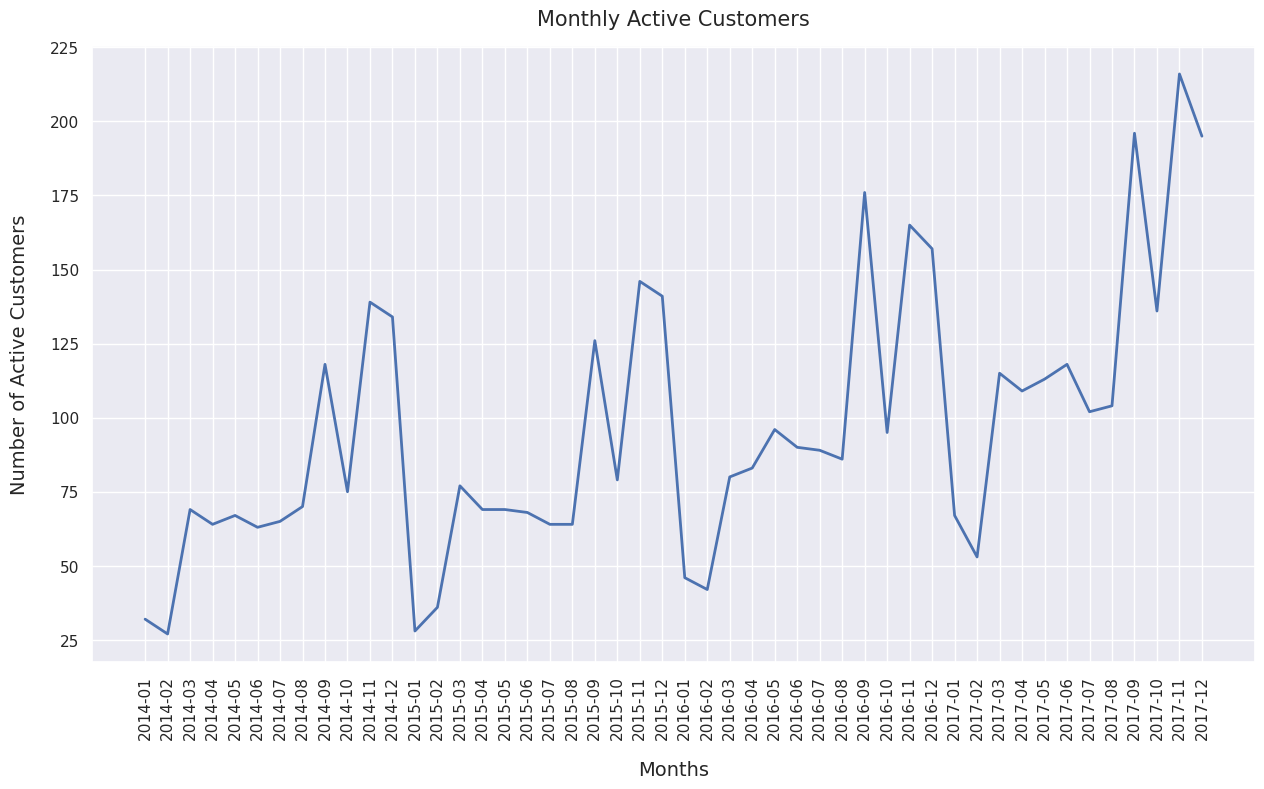

In [12]:
# Calculate number of monthly active customers.
df_active = df.groupby('year_month')['customer_id'].nunique()

# Plot the number of monthly active customers.
plt.figure(figsize=(15,8))
s = sns.lineplot(data=df_active, color='b', linewidth=2, legend=None)
s.set_title('Monthly Active Customers', y=1.02, fontsize=15)
s.set_xlabel('Months', fontsize=14, labelpad=15)
s.set_ylabel('Number of Active Customers', fontsize=14, labelpad=15)
plt.xticks(rotation=90)
plt.show()


Observations:

- The number of active customers increases in Q4 in the lead up to the holidays and Christmas.
- There is a drop off in active customers in January and February each year this can be attributed to customers taking a break after much spending during the festive season
- There is consistent increase in the number of active customers over the years, indicating growth of the customer base year by year.

### Monthly Number of Orders

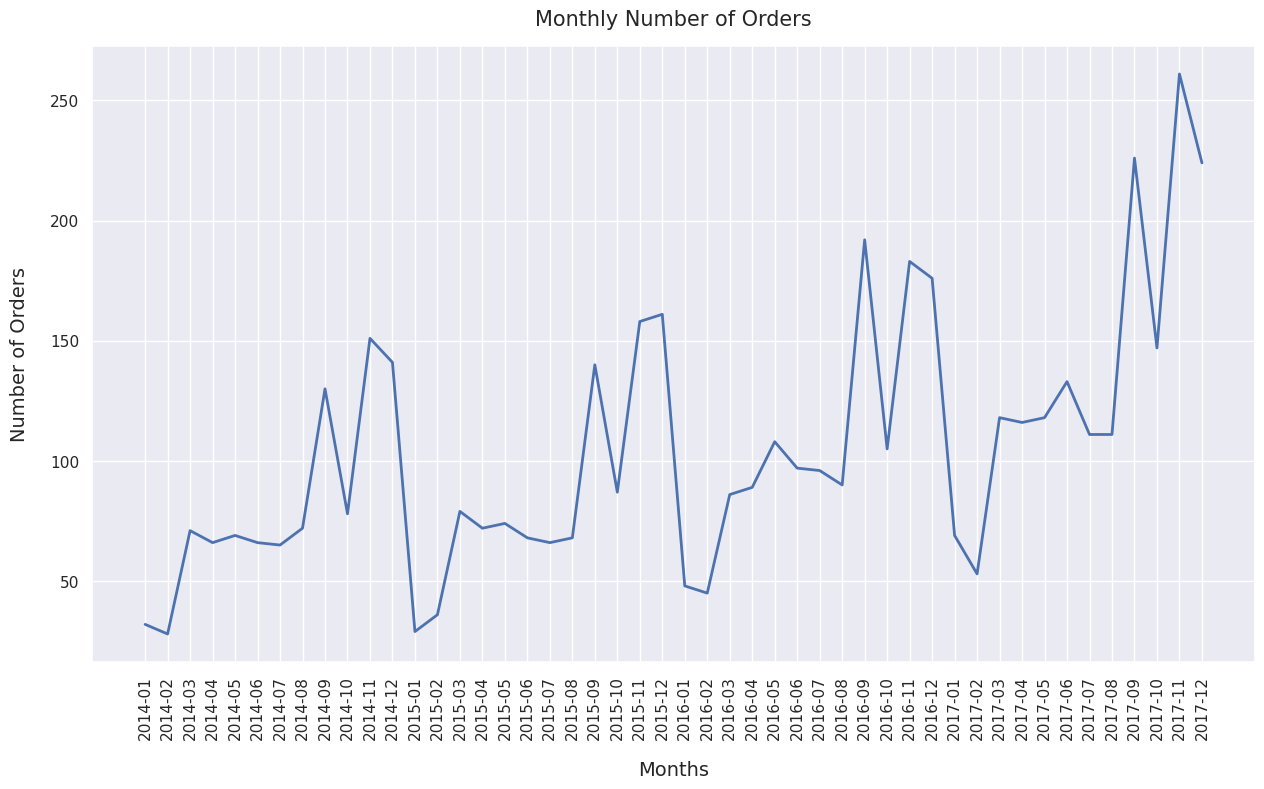

In [13]:
# Calculate number of monthly orders.
df_orders = df.groupby('year_month')['order_id'].nunique().reset_index()

# Plot monthly number of orders.
plt.figure(figsize=(15,8))
s = sns.lineplot(data=df_orders, color='b', linewidth=2, legend=None)
s.set_title('Monthly Number of Orders', y=1.02, fontsize=15)
s.set_xlabel('Months', fontsize=14, labelpad=15)
s.set_ylabel('Number of Orders', fontsize=14, labelpad=15)
plt.xticks(np.arange(len(df_orders['year_month'])), df_orders['year_month'], rotation=90)
plt.show()

In [14]:
# Display top 10 customers by number of orders.
df.groupby('customer_id')['order_id'].nunique().nlargest(10).reset_index()

,customer_id,order_id
0,EP-13915,17
1,CK-12205,13
2,EA-14035,13
3,JE-15745,13
4,NS-18640,13
5,PG-18820,13
6,SH-19975,13
7,ZC-21910,13
8,AH-10690,12
9,BD-11320,12


Observations:

- All the top 10 customers that have a significant number of orders do not bring the highest revenue  but are steady customers


## Customer Segmentation using Recency-Frequency-Monetary (RFM) analysis:

RFM analysis is a customer segmentation technique that uses past purchase behaviour to divide customers into groups. RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services. 

A combination of these three attributes can be defined to assign a quantitative value to customers. e.g. A customer who recently bought high value products and transacts regularly is a high value customer.

### Recency of Customer Purchases
How many days ago was the customer's last purchase.

In [15]:
# Determine the most recent purchase date for each customer and the number of days since.
# Use the most recent purchase date in the dataset as the observation point.
df_recency = df.groupby('customer_id')['order_date'].max().reset_index()
df_recency.columns = ['customer_id','last_purchase_date']
df_recency['recency'] = (df_recency['last_purchase_date'].max() - df_recency['last_purchase_date']).dt.days

In [16]:
df_recency.drop('last_purchase_date',axis = 1,inplace=True)
df_recency.head()

,customer_id,recency
0,AA-10315,184
1,AA-10375,19
2,AA-10480,259
3,AA-10645,55
4,AB-10015,415


### Frequency of Customer Purchases
How often did a customer purchased from us

In [17]:
# Determine the frequency of purchases for each customer.
df_frequency = df.groupby('customer_id')['order_id'].nunique().reset_index()
df_frequency.columns = ['customer_id','frequency']

In [18]:
df_frequency.head()

,customer_id,frequency
0,AA-10315,5
1,AA-10375,9
2,AA-10480,4
3,AA-10645,6
4,AB-10015,3


### Monetary Value of Customer
How much money did the customer spent over time?

In [19]:
# Determine the monetary value for each customer.
df_monetary = df.groupby('customer_id')['revenue'].sum().reset_index()
df_monetary.columns = ['customer_id','monetary_value']

In [20]:
df_monetary.head()

,customer_id,monetary_value
0,AA-10315,16073.344
1,AA-10375,2734.830
2,AA-10480,5493.936
3,AA-10645,22927.855
4,AB-10015,1984.480


In [21]:
df_rfm = df_recency.merge(df_frequency,on='customer_id').merge(df_monetary,on='customer_id')
df_rfm.set_index('customer_id',inplace=True)
df_rfm.head(5)

,recency,frequency,monetary_value
customer_id,,,
AA-10315,184,5,16073.344
AA-10375,19,9,2734.830
AA-10480,259,4,5493.936
AA-10645,55,6,22927.855
AB-10015,415,3,1984.480


## K-means clustering
To gain even further insight into customer behavior, we can dig deeper in the relationship between RFM variables.

RFM model can be used in conjunction with predictive models like K-means clustering algorithm to produce better informative results on customer behavior and the ideal segments of customers.

### Feature Scaling
Since, all the features like Recency, Frequency and Monetary value are within varying ranges of values, we need to standardize them. In addition, the feature like "Monetary value" can take a very large range of values. So, to standardize all the inputs features, we apply log transform,  to bring data into normal or near normal distribution

In [22]:
#Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
    
#Apply handle_neg_n_zero function to Recency and Monetary columns 
df_rfm['recency'] = [handle_neg_n_zero(x) for x in df_rfm['recency']]
df_rfm['monetary_value'] = [handle_neg_n_zero(x) for x in df_rfm['monetary_value']]

#Perform Log transformation to bring data into normal or near normal distribution
df_rfm[["log_recency", "log_frequency", "log_monetary_value"]] = df_rfm[['recency', 'frequency', 'monetary_value']].apply(np.log, axis = 1).round(3)

In [23]:
#Bring the data on same scale
log_df_rfm = df_rfm[["log_recency", "log_frequency", "log_monetary_value"]]
scaleobj = preprocessing.StandardScaler()
Scaled_Data = scaleobj.fit_transform(log_df_rfm)

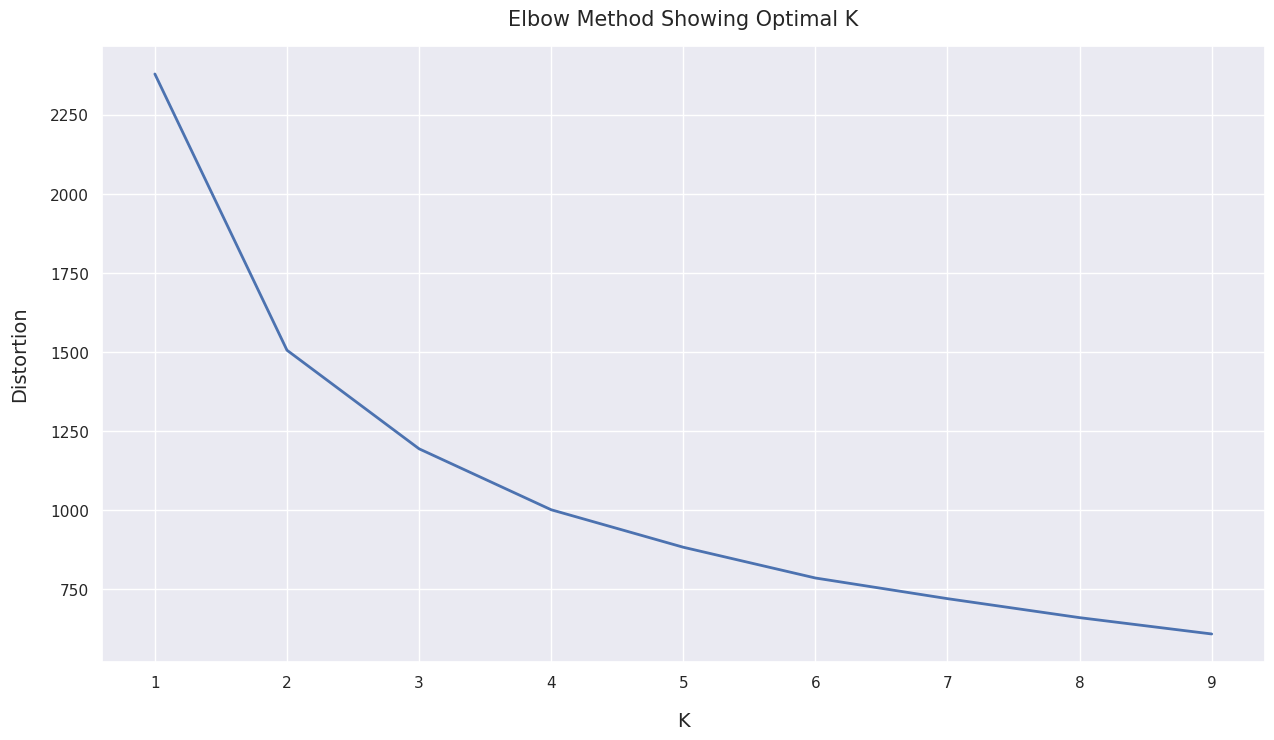

In [24]:
distortions = []
K = range(1,10)
for k in K:
    kmeans_model = KMeans(n_clusters=k)
    kmeans_model.fit(Scaled_Data)
    distortions.append(kmeans_model.inertia_)  

# Plot elbow to identify optimal k.    
plt.figure(figsize=(15,8))
plt.plot(K, distortions, linewidth=2)
plt.xlabel('K', fontsize=14, labelpad=15)
plt.ylabel('Distortion', fontsize=14, labelpad=15)
plt.title('Elbow Method Showing Optimal K', y=1.02, fontsize=15)
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3548731103975884
For n_clusters = 3 The average silhouette_score is : 0.25507488057705685
For n_clusters = 4 The average silhouette_score is : 0.2520811478261321
For n_clusters = 5 The average silhouette_score is : 0.2548407907683872


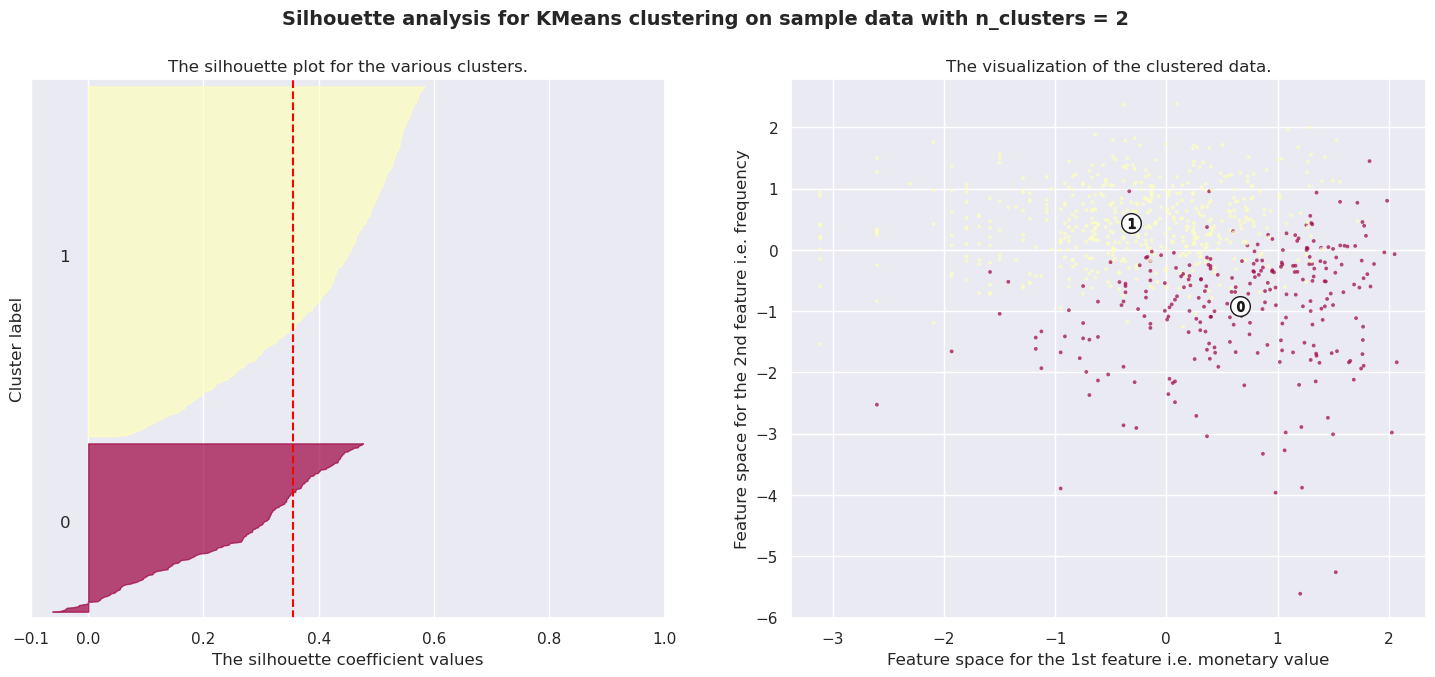

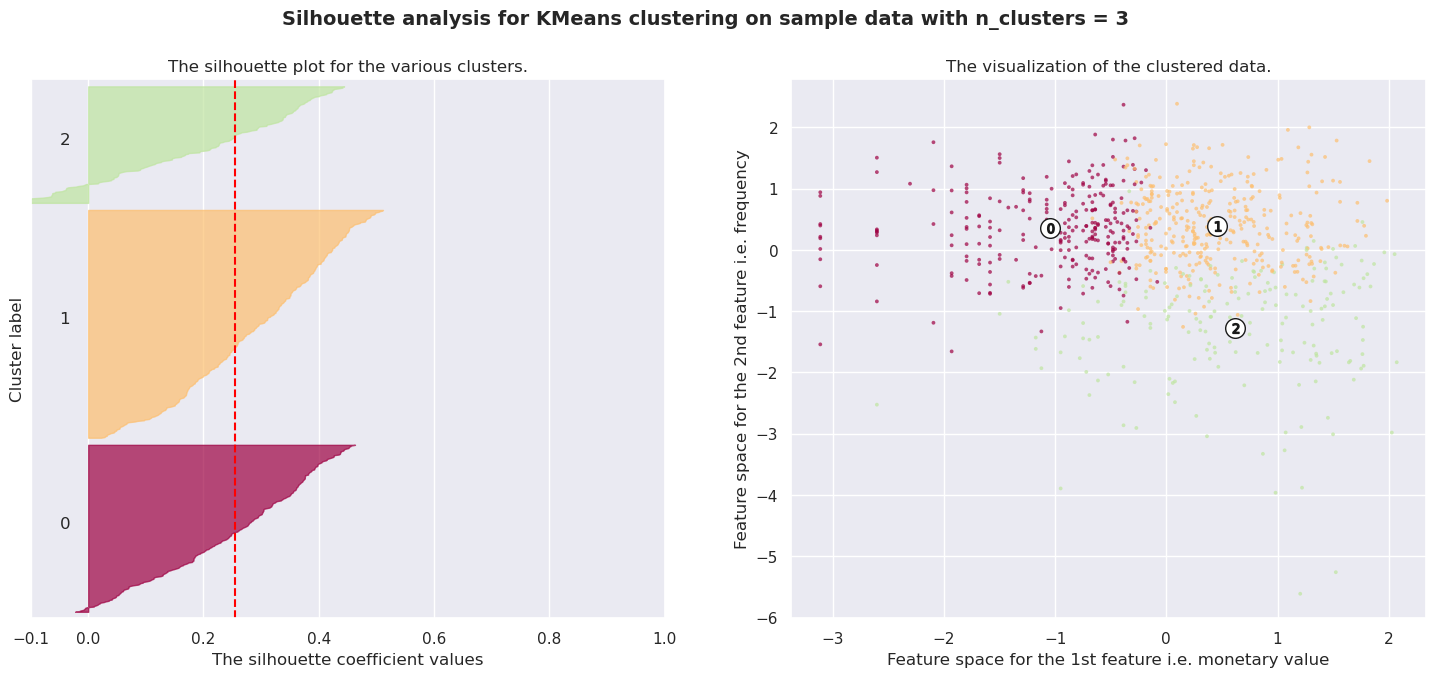

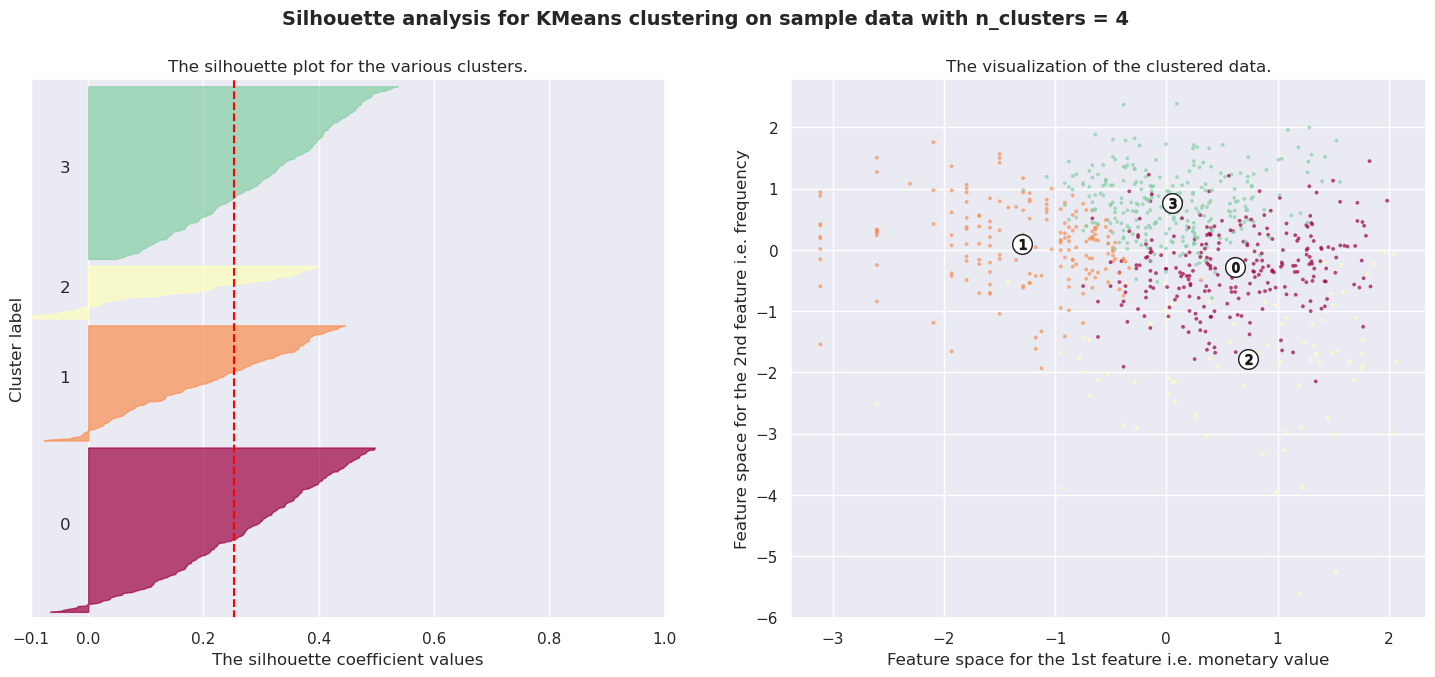

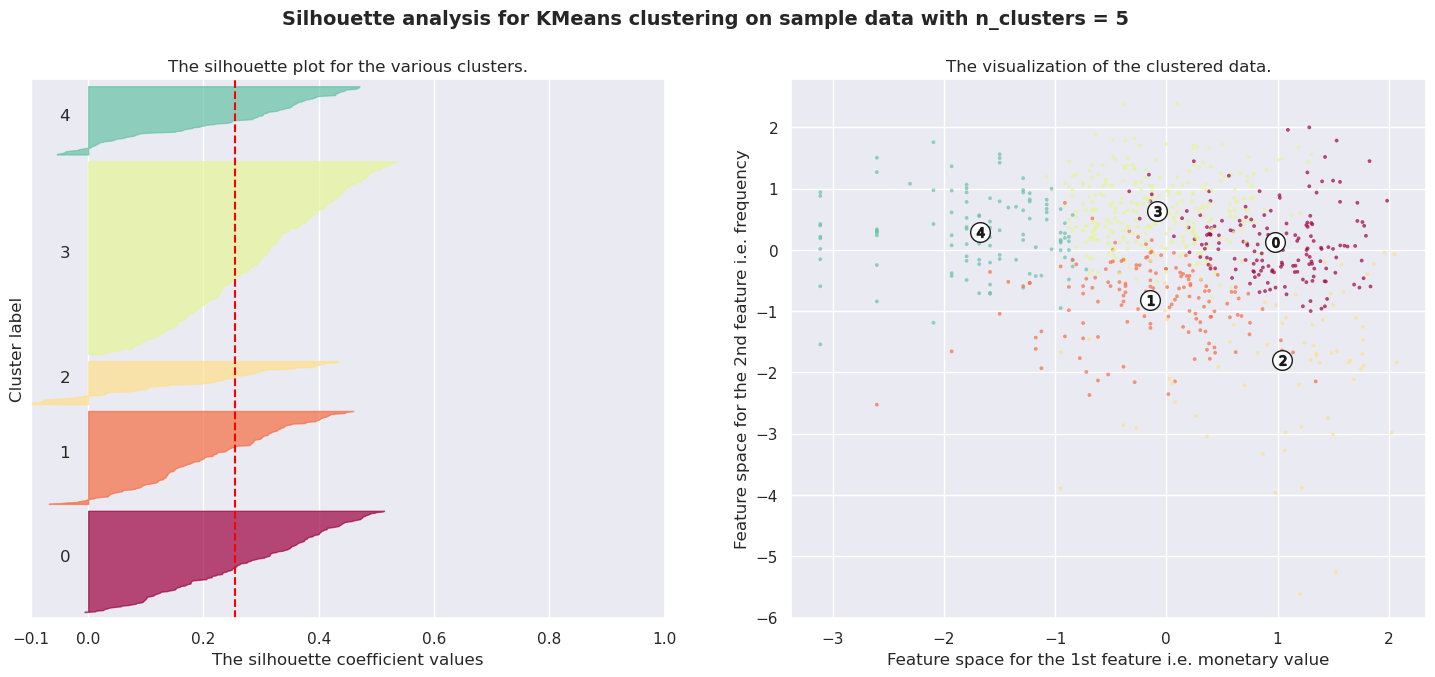

In [25]:
fX = Scaled_Data

cluster_centers = dict()

for n_clusters in range(2,6):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    
    #classify cluster labels based on training data
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    cluster_centers.update({n_clusters :{
                                        'cluster_center':clusterer.cluster_centers_,
                                        'silhouette_score':silhouette_avg,
                                        'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    feature1 = 0
    feature2 = 2
    ax2.scatter(X[:, feature1], X[:, feature2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, feature1], centers[:, feature2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[feature1], c[feature2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature i.e. monetary value")
    ax2.set_ylabel("Feature space for the 2nd feature i.e. frequency")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

We observe from the elbow plot a bend after the number of clusters increase by 3. Silhoutte Score is also the highest for 3 clusters. As from the chart, n_clusters=3, look to be most appropriate than others as it stands good against other clusters because all the plots in n_clusters=3 are more or less of similar thickness and hence are of similar sizes, as can be considered as best ‘k’.

### Business Relevance of different Customer Segments
To reach at any conclusion based on the 3 customer segments we have obtained, we need to inspect the recency, frequency and monetary values associated with each cluster. First, we need to convert back the log transformed values.

In [26]:
print("for 3 number of clusters")
cent_transformed = scaleobj.inverse_transform(cluster_centers[3]['cluster_center'])
print(pd.DataFrame(np.exp(cent_transformed),columns=["log_recency", "log_frequency", "log_monetary_value"]))

for 3 number of clusters
   log_recency  log_frequency  log_monetary_value
0    16.565983       7.462424        12997.264724
1   128.223312       6.390775        13578.817068
2   161.580832       3.183278         1871.017293


### Observations from the Three Clusters (Customer Segments):

Carefully examining the three cluster classification, these are the observed groups of customers:

**1. High monetary value customer:**

'Cluster 1' represents a peculiar customer segment who place quite a high valued order with a high relative frequency but not purchased much recently. These customers do hold a lot of promise if targeted to improve sales.

**2. Medium value customer:**

'Cluster 0' appears to be the medium valued customer segment. These customers place an order of a considerable amount almost close to the high value customers. Their orders are more frequent than other customers and also the ones who have transacted the most recently.

**3. Low value customer:**

It is quite evident that 'Cluster 2' has customers who rarely shop and when they order, their orders are pretty low valued. These customers will have the tendency to churn, creating targeted strategies that can capture their attention will help

**4.** It is interesting to see that customers with most frequent orders also fall into the category of the customers that buy when there is discount. These customers will aleays buy something during discount seasons so alarting them during those period would be better


**Marketing Strategies**: 

Following priorities of actions for low value customers, running surveys first is important as that helps to know exactly what went wrong with the customers, then follows personalization based on their previous purchases as sometimes customers might need something and not realize they do until they see the ad or recommendation,  then follows promotions.

Personalized offers will work for those who are not coming to the eshop at all. Also sending out newsletters after a period of time to make them aware that an eshop like this exists and would love to have them back can help too.
